In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import copy
import random
import warnings
warnings.filterwarnings('ignore')

random.seed(42)

In [20]:
df = pd.read_csv('data.csv',index_col=0)
df1 = copy.deepcopy(df) 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410 entries, 2020-03-03 to 2021-04-16
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   CASE_COUNT                                          410 non-null    int64  
 1   PROBABLE_CASE_COUNT                                 410 non-null    int64  
 2   CASE_COUNT_7DAY_AVG                                 410 non-null    int64  
 3   ALL_CASE_COUNT_7DAY_AVG                             410 non-null    int64  
 4   DEATH_COUNT                                         410 non-null    int64  
 5   PROBABLE_DEATH_COUNT                                410 non-null    int64  
 6   DEATH_COUNT_7DAY_AVG                                410 non-null    int64  
 7   ALL_DEATH_COUNT_7DAY_AVG                            410 non-null    int64  
 8   TOTAL_TESTS                                         410 non-null    i

In [22]:
df = df.astype(float)

In [23]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_train = scaler.transform(df)

In [24]:
trainX = []
trainY = []
n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_train) - n_future +1):
    trainX.append(df_train[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_train[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (403, 7, 27).
trainY shape == (403, 1).


In [25]:

testX = trainX[-60:]
testY = trainY[-60:]

trainX = trainX[:-60]
trainY = trainY[:-60]

trainDates = df1.index[:-60]
testDates = df1.index[-60:]

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (343, 7, 27).
trainY shape == (343, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).


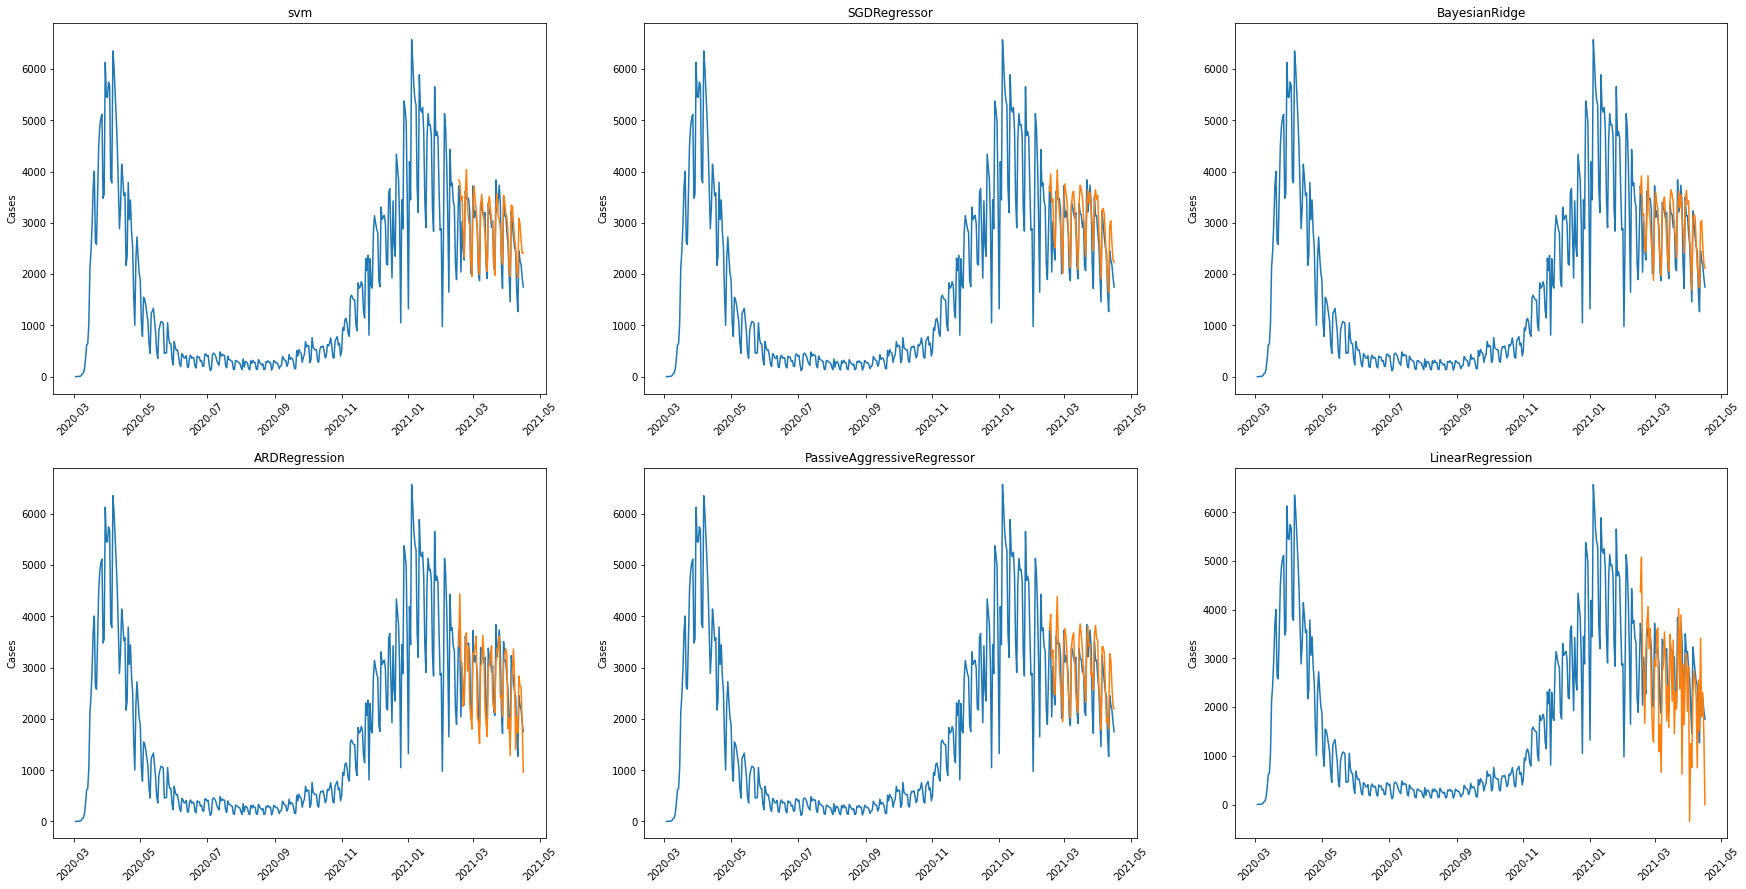

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(random_state=42),
    linear_model.BayesianRidge(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(random_state=42),
    linear_model.LinearRegression()]

nsamples, nx, ny = trainX.shape
train_new_dataset = trainX.reshape((nsamples,nx*ny))
nsamples, nx, ny = testX.shape
test_new_dataset = testX.reshape((nsamples,nx*ny))


df1['Date'] = pd.to_datetime(df1.index)

fig, axs = plt.subplots(2,3, figsize=(30, 15))

classifiers_names = ['svm','SGDRegressor','BayesianRidge','ARDRegression','PassiveAggressiveRegressor','LinearRegression']

MSE_scores = []
MAE_scores = []
R2_scores = []

axs = axs.ravel()   

i=0
for item in classifiers:
    # print(item)
    clf = item
    clf.fit(train_new_dataset, trainY.ravel())
    forecast = (clf.predict(test_new_dataset))
    forecast = forecast.reshape(len(forecast), 1, 1)
    forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
    y_pred_future = y_pred_future[:,0]
    df_forecast = pd.DataFrame({'Date':testDates, 'Cases':y_pred_future})
    df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
    original = df[['CASE_COUNT']]
    original['Date']=pd.to_datetime(df.index)
    original = original.loc[original['Date'] >= '2020-4-1']
    axs[i].set_title(classifiers_names[i])
    axs[i].set_ylabel('Cases')
    axs[i].plot(df1['Date'], df1['CASE_COUNT'])
    axs[i].plot(df_forecast['Date'], df_forecast['Cases'])
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
    i+=1
    # print("R^2 value is : ",r2_score(df_train[-60:,0],forecast.reshape(len(forecast),1)))
    # print("MSE value is : ",mean_squared_error(df_train[-60:,0],forecast.reshape(len(forecast),1)))
    # print("MAE value is : ",mean_absolute_error(df_train[-60:,0],forecast.reshape(len(forecast),1)))
    R2_scores.append(r2_score(df_train[-60:,0],forecast.reshape(len(forecast),1)))
    MSE_scores.append(mean_squared_error(df_train[-60:,0],forecast.reshape(len(forecast),1)))
    MAE_scores.append(mean_absolute_error(df_train[-60:,0],forecast.reshape(len(forecast),1)))
    # classifiers_names.append(str(item))

plt.show()
evaluation = [MSE_scores,MAE_scores,R2_scores]

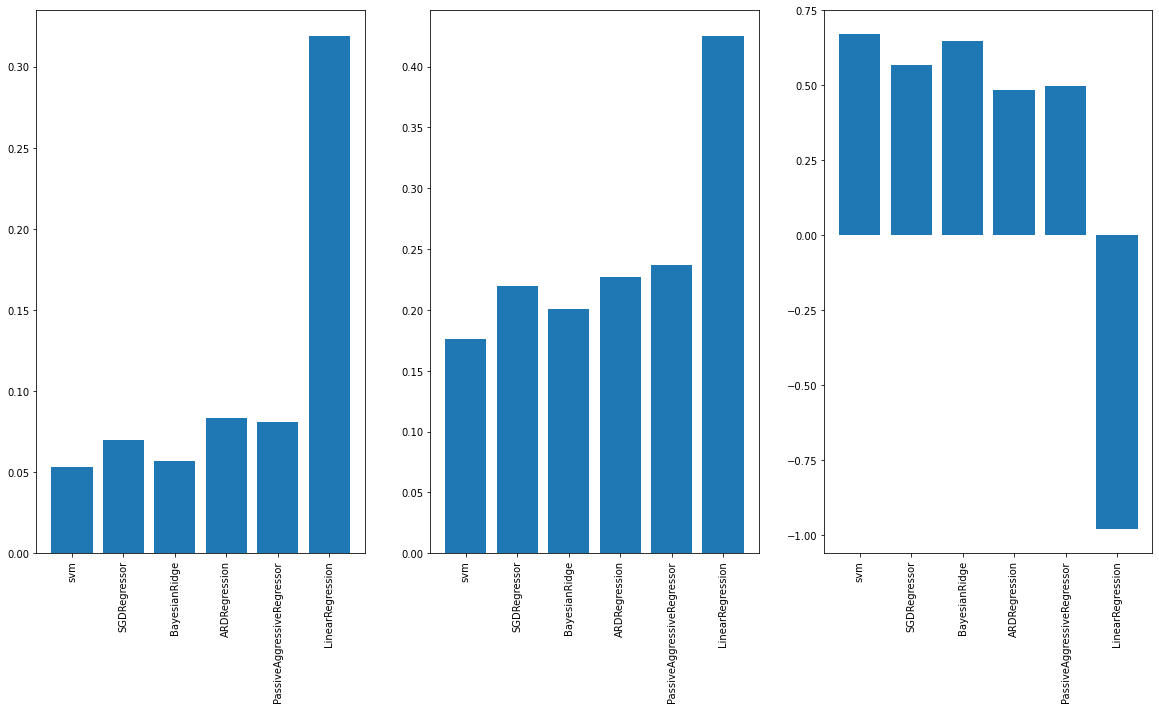

In [27]:
fig, axs = plt.subplots(1,3, figsize=(20, 10))
axs = axs.ravel()

# print(classifiers_names)

for i in range(3):
    axs[i].bar(classifiers_names,evaluation[i])
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)